In [1]:

# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #serpara los datos 
from sklearn.metrics import confusion_matrix, classification_report #estos los regulatado las claisigfacion y la matriz de confusion
from sklearn.preprocessing import StandardScaler #normalizar los datos 


In [2]:


def to_classlabel(z):
    return z.argmax(axis = 1) #etiqeuta en la columna


In [3]:
def one_hot_encode(y):
    n_class = np.unique(y).shape[0] #cunatas clases tiene Y 
    y_encode = np.zeros((y.shape[0], n_class)) #inicialzia la tabla, rengloes(instancias ) columnas numero de clases
    for idx, val in enumerate(y):
        y_encode[idx, val] = 1.0
    return y_encode


In [4]:
# Define Accuracy
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc #presicion 


In [5]:

class Logistic_Regression_AdamD():
    
    def __init__(self, lambda_param=0.01):
        self.theta = None
        self.lambda_param = lambda_param  # Parámetro de regularización L2
        
    
    def _sigmoid(self, A, theta):
        yh = np.dot(A, theta)
        # Añadir clip para estabilidad numérica
        yh = np.clip(yh, -500, 500)
        return 1/(1 + np.exp(-yh))



    #fiunciond e cosot binaria 
    """def _loss(self, y, h):
        '''
        a really small value 'epsilon' is added to avoid 
        overflow and divison by zero error for log
        loss = (-1/q) * sum(y * log(h) + (1-y) * log(1 - h))
        where h = 1/(1 + e^(-yh))
        '''
        #el epsislon funciona por si la hipotrsis nos da 0 (log -> logaritmo natural )
        epsilon = 1e-5
        # modificacion 
        h = np.clip(h, epsilon, 1 - epsilon)
        # Pérdida con regularización L2
        reg_term = (self.lambda_param/(2*len(y))) * np.sum(self.theta[1:]**2)
        los = (-1/len(y)) * np.sum(y * np.log(h + epsilon) + (1-y) * np.log(1-h+epsilon)) + reg_term
        return los"""
    
    def _loss(self, y, h, theta):
        ''' Función de pérdida: entropía cruzada binaria con regularización L2 '''
        epsilon = 1e-5
        h = np.clip(h, epsilon, 1 - epsilon)
        n = len(y)
        # Término de entropía cruzada
        loss = - (1/n) * np.sum(y * np.log(h) + (1-y) * np.log(1-h))
        # Término de regularización L2 (excluimos el sesgo, theta[0])
        reg_term = (self.lambda_param/(2*n)) * np.sum(theta[1:]**2)
        return loss + reg_term
    
    def gradient(self, A, y, h, theta):
        ''' Gradiente de la pérdida con regularización L2 '''
        n = len(y)
        error = h - y
        grad = (1/n) * np.dot(A.T, error)
        # Regularización L2 (excluyendo el sesgo)
        grad[1:] += (self.lambda_param/n) * theta[1:]
        return grad

    def fit(self, A, y, learning_rate=0.001, beta1=0.9, beta2=0.999, 
            epsilon=1e-8, epochs=100, batch_size=32, show_step=10, 
            stopping_threshold=1e-6, verbose=False):
        ''' 
        Entrenamiento con AdamD 
        Parámetros:
        -----------
        A: matriz de diseño (incluye columna de unos)
        y: vector de etiquetas (0 o 1)
        learning_rate: tasa de aprendizaje (alpha)
        beta1, beta2: parámetros de momento
        epsilon: constante de estabilidad numérica
        epochs: número máximo de épocas
        batch_size: tamaño del minilote
        show_step: cada cuántas épocas mostrar información
        stopping_threshold: umbral de parada temprana (cambio en pérdida)
        verbose: si True, imprime progreso
        '''
        n_obs, n_features = A.shape
        # Inicialización aleatoria como en GDX
        self.theta = np.random.randn(n_features) * 0.01
        m = np.zeros(n_features)
        v = np.zeros(n_features)
        t = 0
        
        epoch_losses = []
        previous_loss = np.inf
        
        for epoch in range(epochs):
            # Barajar los datos
            permutation = np.random.permutation(n_obs)
            A_shuffled = A[permutation]
            y_shuffled = y[permutation]
            
            epoch_loss = 0.0
            n_batches = n_obs // batch_size
            residual = n_obs % batch_size
            total_batches = n_batches + (1 if residual != 0 else 0)
            
            for batch_idx in range(total_batches):
                t += 1
                start = batch_idx * batch_size
                end = start + batch_size
                # Manejo robusto de batch residual como en GDX
                if batch_idx == total_batches - 1 and residual != 0:
                    end = start + residual
                
                A_batch = A_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                h_batch = self._sigmoid(A_batch, self.theta)
                loss_batch = self._loss(y_batch, h_batch, self.theta)
                epoch_loss += loss_batch * len(y_batch)
                
                grad = self.gradient(A_batch, y_batch, h_batch, self.theta)
                
                # Actualización AdamD
                m = beta1 * m + (1 - beta1) * grad
                v = beta2 * v + (1 - beta2) * (grad ** 2)
                
                # Corrección de bias como en el algoritmo original
                alpha_t = learning_rate * np.sqrt(1 - beta2**t)
                
                self.theta -= alpha_t * m / (np.sqrt(v) + epsilon)
            
            epoch_loss /= n_obs
            epoch_losses.append(epoch_loss)
            
            # Parada temprana mejorada
            if epoch > 10 and abs(previous_loss - epoch_loss) < stopping_threshold:
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break
                
            previous_loss = epoch_loss
            
            if verbose and epoch % show_step == 0:
                print(f'Epoch: {epoch}, Loss: {epoch_loss:.6f}')
        
        return self.theta, epoch_losses
    
    def predict(self, A, threshold=0.5):
        y_predicted = self._sigmoid(A, self.theta)
        # Usar vectorización en lugar de comprensión de lista
        return (y_predicted >= threshold).astype(int)



In [6]:

class Logistic_Regression_AdamD_Multiclass():
    def __init__(self, lambda_param=0.01, num_classes=6):
        self.models = []
        self.losses = []
        self.lambda_param = lambda_param
        self.num_classes = num_classes
        
    def fit(self, A, y, **fit_params):
        self.models = []
        self.losses = []
        
        for i in range(self.num_classes):
            y_binary = np.where(y == i, 1, 0)
            
            positive_indices = np.where(y_binary == 1)[0]
            negative_indices = np.where(y_binary == 0)[0]
            
            n_pos = len(positive_indices)
            
            if n_pos > 0:
                neg_selected = np.random.choice(negative_indices, size=n_pos, replace=False)
                balanced_indices = np.concatenate([positive_indices, neg_selected])
                np.random.shuffle(balanced_indices)
                
                A_balanced = A[balanced_indices]
                y_balanced = y_binary[balanced_indices]
            else:
                print(f"Advertencia: Clase {i} tiene 0 muestras positivas")
                A_balanced = A
                y_balanced = y_binary
                
            model = Logistic_Regression_AdamD(lambda_param=self.lambda_param)
            theta, epoch_losses = model.fit(A_balanced, y_balanced, **fit_params)
            self.models.append(model)
            self.losses.append(epoch_losses)
    
    def predict_proba(self, A):
        probas = []
        for model in self.models:
            proba = model._sigmoid(A, model.theta)
            probas.append(proba)
        return np.array(probas).T
    
    def predict(self, A):
        probas = self.predict_proba(A)
        return np.argmax(probas, axis=1)


In [7]:


# # Read the data
# data = np.loadtxt('admisiones_dataset.txt',delimiter=',')
# inputs = data[:,0:2]
# idx = 2-data[:,2] #restamos el 1 para establecer el categorico, adminitivos - 1 no admitivos - 0 
# targets = np.array(idx, dtype=int)     # codificacion categorica
# # targets = one_hot_encode(labels)      # one hot encode to classlabel

try:
    df = pd.read_csv('dermatology.dat', header=None, na_values='?', delimiter=r'\s+')
    
    inputs = df.iloc[:, 0:34]
    targets = df.iloc[:, 34]
    
    age_mean = inputs[33].mean()
    inputs[33] = inputs[33].fillna(age_mean)
    
    inputs = inputs.astype(float)
    targets = targets.astype(int) - 1  # Convertir clases [1-6] a [0-5]

except Exception as e:
    print(f"Error al leer el archivo: {e}")
    exit()



C:\Users\erikG\AppData\Local\Temp\ipykernel_5816\3446328204.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs[33] = inputs[33].fillna(age_mean)


In [8]:


# Split the data
# x_train,x_test,y_train,y_test = train_test_split(inputs,targets,test_size=0.40,random_state=1234) # test_size genreta entrenamiento y prueba 

# División de datos
x_train, x_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.3, random_state=42
)


In [9]:
# Normalización
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



In [10]:
#matrices de disenio, 
A_train = np.c_[np.ones(len(x_train)), x_train]
A_test  = np.c_[np.ones(len(x_test)), x_test]


In [11]:

# Parámetros para el constructor

#minilot4es
# Hiperparámetros para AdamD
lambda_param = 0.01  # Regularización L2
fit_params = {
    'learning_rate': 1e-4,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8,
    'epochs': 1000,
    'batch_size': 128, 
    'show_step': 100,
    'stopping_threshold': 1e-6,
    'verbose': True
}


#online
# lambda_param = 0.01  # Regularización L2
# fit_params = {
#     'learning_rate': 1e-4,
#     'beta1': 0.9,
#     'beta2': 0.999,
#     'epsilon': 1e-8,
#     'epochs': 1000,
#     'batch_size': 1,  
#     'show_step': 100,
#     'stopping_threshold': 1e-4,
#     'verbose': True
# }


#lote completo
    # lambda_param = 0.01  # Regularización L2
    # fit_params = {
    #     'learning_rate': 1e-4,
    #     'beta1': 0.9,
    #     'beta2': 0.999,
    #     'epsilon': 1e-8,
    #     'epochs': 1000,
    #     'batch_size': len(y_train),  
    #     'show_step': 100,
    #     'stopping_threshold': 1e-4,
    #     'verbose': True
    # }


In [12]:

# # Build and fit best LR model
# alpha = 0.01 #lr
# maxEpochs = 5000
# batch = 10 #minilotes
# show = 500 #view

# # Build model
# log_model = Logistic_Regression()
# # Fit Model
# theta, batch_loss, epoch_loss = log_model.fit(A_train, y_train, learning_rate=alpha, 
#                                 epochs=maxEpochs, batch_size=batch, show_step = show, verbose=True)


# Entrenamiento del modelo
model = Logistic_Regression_AdamD_Multiclass(lambda_param=lambda_param, num_classes=6)
model.fit(A_train, y_train, **fit_params)


Epoch: 0, Loss: 0.687128
Epoch: 100, Loss: 0.571548
Epoch: 200, Loss: 0.481543
Epoch: 300, Loss: 0.412490
Epoch: 400, Loss: 0.359222
Epoch: 500, Loss: 0.317117
Epoch: 600, Loss: 0.283174
Epoch: 700, Loss: 0.255102
Epoch: 800, Loss: 0.231353
Epoch: 900, Loss: 0.211022
Epoch: 0, Loss: 0.690883
Epoch: 100, Loss: 0.649001
Epoch: 200, Loss: 0.608052
Epoch: 300, Loss: 0.571856
Epoch: 400, Loss: 0.539886
Epoch: 500, Loss: 0.511627
Epoch: 600, Loss: 0.486600
Epoch: 700, Loss: 0.464373
Epoch: 800, Loss: 0.444561
Epoch: 900, Loss: 0.426832
Epoch: 0, Loss: 0.699038
Epoch: 100, Loss: 0.638667
Epoch: 200, Loss: 0.582572
Epoch: 300, Loss: 0.535230
Epoch: 400, Loss: 0.494796
Epoch: 500, Loss: 0.459853
Epoch: 600, Loss: 0.429347
Epoch: 700, Loss: 0.402467
Epoch: 800, Loss: 0.378580
Epoch: 900, Loss: 0.357191
Epoch: 0, Loss: 0.685887
Epoch: 100, Loss: 0.644294
Epoch: 200, Loss: 0.603675
Epoch: 300, Loss: 0.567840
Epoch: 400, Loss: 0.536230
Epoch: 500, Loss: 0.508323
Epoch: 600, Loss: 0.483636
Epoch: 70

In [13]:

# Predicciones y evaluación
# Predicciones
train_pred = model.predict(A_train)
test_pred = model.predict(A_test)


In [14]:

# # Calculate accuracy
# train_acc = accuracy(y_train, train_pred)
# print(f'Accuracy on training set: {train_acc}')
#resultados finales
# Resultados en entrenamiento
print("\nRendimiento en entrenamiento (multiclase - AdamD):")
print(f'Accuracy: {accuracy(y_train, train_pred):.4f}')
print("\nMatriz de confusión:")
print(confusion_matrix(y_train, train_pred))
print("\nReporte de clasificación:")
print(classification_report(y_train, train_pred))



Rendimiento en entrenamiento (multiclase - AdamD):
Accuracy: 0.9688

Matriz de confusión:
[[72  0  0  0  0  0]
 [ 1 38  0  6  0  0]
 [ 0  0 53  0  0  0]
 [ 0  1  0 33  0  0]
 [ 0  0  0  0 36  0]
 [ 0  0  0  0  0 16]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       0.97      0.84      0.90        45
           2       1.00      1.00      1.00        53
           3       0.85      0.97      0.90        34
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        16

    accuracy                           0.97       256
   macro avg       0.97      0.97      0.97       256
weighted avg       0.97      0.97      0.97       256



In [15]:


# Calculate metrics - son de entrenamiento 
# cm_train = confusion_matrix(y_train, train_pred)
# train_report = classification_report(y_train, train_pred)

# print("Performance on training set:\n")
# print(f'Confusion Matrix:\n {cm_train}\n')
# print(f'Classification Report:\n {train_report}')

# Resultados en prueba
print("\nRendimiento en prueba (multiclase - AdamD):")
print(f'Accuracy: {accuracy(y_test, test_pred):.4f}')
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, test_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, test_pred))



Rendimiento en prueba (multiclase - AdamD):
Accuracy: 0.9636

Matriz de confusión:
[[40  0  0  0  0  0]
 [ 0 14  0  2  0  0]
 [ 0  0 19  0  0  0]
 [ 0  1  0 13  1  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  0  0  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.88      0.90        16
           2       1.00      1.00      1.00        19
           3       0.87      0.87      0.87        15
           4       0.94      1.00      0.97        16
           5       1.00      1.00      1.00         4

    accuracy                           0.96       110
   macro avg       0.96      0.96      0.96       110
weighted avg       0.96      0.96      0.96       110



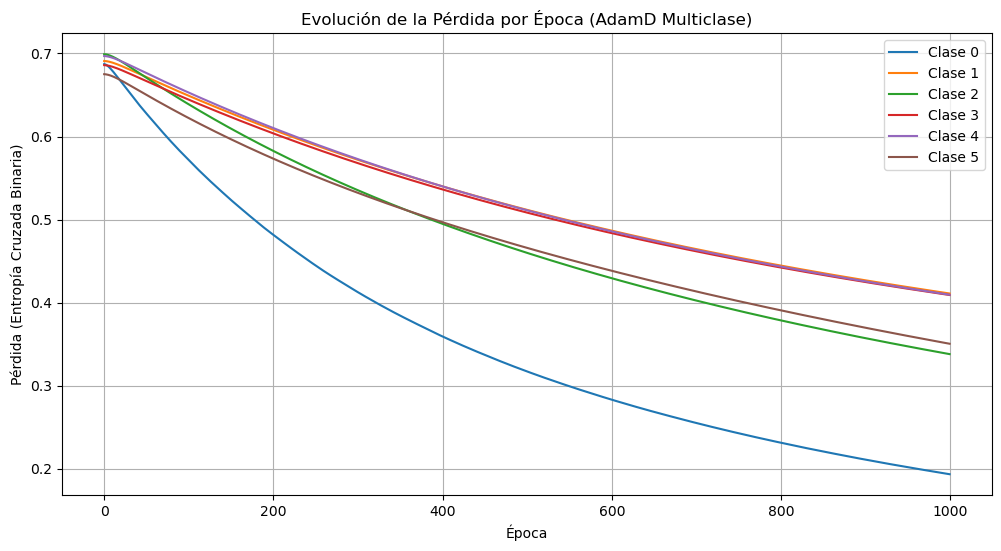

In [16]:
# Gráfica de pérdida
plt.figure(figsize=(12, 6))
for i, loss_list in enumerate(model.losses):
    plt.plot(loss_list, label=f'Clase {i}')
plt.title('Evolución de la Pérdida por Época (AdamD Multiclase)')
plt.xlabel('Época')
plt.ylabel('Pérdida (Entropía Cruzada Binaria)')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'Logistic_Regression_AdamD_Multiclass' object has no attribute 'theta'